<a href="https://colab.research.google.com/github/Lvl1Programmer/DataScienceTopics/blob/main/PlayingAroundWithTimeSeriesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playing Around With Time Series Data
Here we will be playing with a couple different time series dataset to explore more on the statistical modeling.


# Initialize Libraries and Datasets

In [1]:
!kaggle datasets download 'protobioengineering/mit-bih-arrhythmia-database-modern-2023' # EKG Data

Dataset URL: https://www.kaggle.com/datasets/protobioengineering/mit-bih-arrhythmia-database-modern-2023
License(s): CC-BY-SA-4.0
 99% 232M/235M [00:01<00:00, 127MB/s]
100% 235M/235M [00:01<00:00, 135MB/s]


In [2]:
!unzip -q 'mit-bih-arrhythmia-database-modern-2023.zip'

In [3]:
!pip install statsmodels pmdarima -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Intro to Data
A beginner-friendly version of the MIT-BIH Arrhythmia Database, which contains 48 electrocardiograms (EKGs) from 47 patients that were at Beth Israel Deaconess Medical Center in Boston, MA in 1975-1979.

There are 48 CSVs, each of which is a 30-minute echocardiogram (EKG) from a single patient (record 201 and 202 are from the same patient). Data was collected at 360 Hz, meaning that 360 data points is equal to 1 second of time.

EKGs, or electrocardiograms, measure the heart's function by looking at its electrical activity. The electrical activity in each part of the heart is supposed to happen in a particular order and intensity, creating that classic "heartbeat" line (or "QRS complex") you see on monitors in medical TV shows.

There are a few types of EKGs (4-lead, 5-lead, 12-lead, etc.), which give us varying detail about the heart. A 12-lead is one of the most detailed types of EKGs, as it allows us to get 12 different outputs or graphs, all looking at different, specific parts of the heart muscles.

This dataset only publishes two leads from each patient's 12-lead EKG, since that is all that the original MIT-BIH database provided.

## Filenames
Each file's name is the ID of the patient (except for 201 and 202, which are the same person).

## Columns
index
calculated elapsed milliseconds (index / 360 * 1000)
the first lead
the second lead
The two leads are often lead MLII and another lead such as V1, V2, or V5, though some datasets do not use MLII at all. MLII is the lead most often associated with the classic QRS Complex (the medical name for a single heartbeat).

Milliseconds were calculated and added as a secondary index to each dataset. Calculations were made by dividing the index by 360 Hz then multiplying by 1000. The original index was preserved, since the calculation of milliseconds as digital signals processing (e.g. filtering) occurs may cause issues with the correlation and merging of data. You are encouraged to try whichever index is most suitable for your analysis and/or recalculate a time index with Pandas' to_timedelta().

# Load data + EDA

In [5]:
df = pd.read_csv('100.csv')

In [6]:
df.head()

,Unnamed: 0,time_ms,MLII,V5
0,0,0.000000,-0.145,-0.065
1,1,2.777778,-0.145,-0.065
2,2,5.555556,-0.145,-0.065
3,3,8.333333,-0.145,-0.065
4,4,11.111111,-0.145,-0.065


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  650000 non-null  int64  
 1   time_ms     650000 non-null  float64
 2   MLII        650000 non-null  float64
 3   V5          650000 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 19.8 MB


In [8]:
df.time_ms = pd.to_timedelta(df.time_ms, unit='ms')

In [9]:
df.set_index(df.time_ms,inplace=True)
df.drop(['time_ms','Unnamed: 0'],axis=1,inplace=True)

In [10]:
df.head()

,MLII,V5
time_ms,,
0 days 00:00:00,-0.145,-0.065
0 days 00:00:00.002777778,-0.145,-0.065
0 days 00:00:00.005555556,-0.145,-0.065
0 days 00:00:00.008333333,-0.145,-0.065
0 days 00:00:00.011111111,-0.145,-0.065


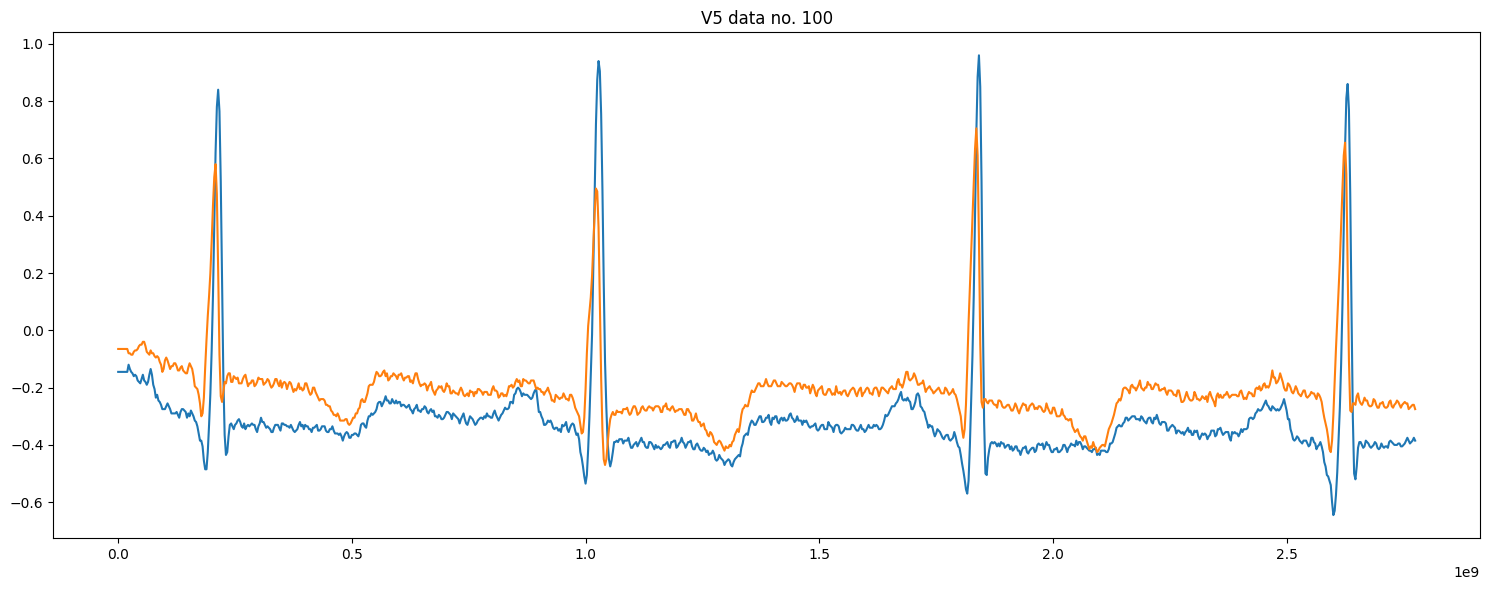

In [11]:
plt.figure(figsize=(15,6))
plt.plot(df.MLII[:1000])
plt.title('MLII data no. 100')
plt.plot(df.V5[:1000])
plt.title('V5 data no. 100')

plt.tight_layout()
plt.show()

# Lets do analysis on patient 100

## Stationary Testing
What is Stationarity, in simple terms mean and variance over the time series don't change

## **Stationarity**
A stationary time series is one where **statistical properties** like mean, variance, and autocorrleation do not change over time. It is important in many statistical models like ARIMA that require the data to be stationary to make reliable predictions.

E.g.
- Non-stationary data have **trends, seasonality, or changing variance**, making them harder to model directly.
- Stationary data stays consistent over time, which is easier to model because it doesn't have trends.


## **ADF (Augmented Dickey Fuller) Test**
### Purpose:
To check if a time series is stationary. Specifically test for the presence of a **unit root**.(If there's one, it means it's non-stationary)

### Hypotheses:
- Null Hypotehsis (H₀): The series has a unit root (non-stationary)
- Alternative Hypothesis (H₁): The sries does not have unit root (stationary)

### Method:
Fits regression model to time series and check whether lagged version significantly affects the current value. It includes "augmented" terms(lagged differences) to account for autocorrelatiojn in the series.

## **KPSS (Kwiatkowski-Phillips-Schimdt-Shin) Test**
Another way to test for stationarity but works differntly from ADF test, it tests for unit root(stationarity around a trend)

### Hypotheses:
- Null Hypothesis (H₀): The series is stationary.
- Alternative Hypothesis (H₁): The series is non-stationary (has a unit root).

### Method
Decomposes time series into 3 components:
1. Deterministic trend, random walk, stationary error.
2. Checks if random walk has a non-zero variance(indiicates non-stationarity)



In [12]:
# To Test this we will use
# Augmented Dickey-Fuller(ADF) test
from statsmodels.tsa.stattools import adfuller

df_downsampledV5 = df['V5'].resample('s').mean()
df_downsampledMLII = df['MLII'].resample('s').mean()

# Perform ADF test
adf_resultV5 = adfuller(df_downsampledV5)
adf_resultMLII = adfuller(df_downsampledMLII)

# Display results
print('ADF Statistic:', adf_resultV5[0])
print('p-value:', adf_resultV5[1])
print('Critical Values:', adf_resultV5[4])

print('ADF Statistic:', adf_resultMLII[0])
print('p-value:', adf_resultMLII[1])
print('Critical Values:', adf_resultMLII[4])

# Interpretation
if adf_resultV5[1] < 0.05:
    print("Lead 1 is stationary")
else:
    print("Lead 1 is non-stationary")

if adf_resultMLII[1] < 0.05:
    print("Lead 2 is stationary")
else:
    print("Lead 2 is non-stationary")


ADF Statistic: -3.8394868258804173
p-value: 0.0025281898236267242
Critical Values: {'1%': -3.43402700734663, '5%': -2.8631641942387542, '10%': -2.56763466996284}
ADF Statistic: -6.484410662938089
p-value: 1.2714050887656363e-08
Critical Values: {'1%': -3.434022876868246, '5%': -2.8631623708604996, '10%': -2.5676336990659903}
Lead 1 is stationary
Lead 2 is stationary


In [13]:
from statsmodels.tsa.stattools import kpss

kpss_resultV5 = kpss(df_downsampledV5, regression='c', nlags="auto")
kpss_resultMLII = kpss(df_downsampledMLII, regression='c', nlags="auto")

# Display results
print('KPSS Statistic:', kpss_resultV5[0])
print('p-value:', kpss_resultV5[1])
print('Critical Values:', kpss_resultV5[3])

print('KPSS Statistic:', kpss_resultMLII[0])
print('p-value:', kpss_resultMLII[1])
print('Critical Values:', kpss_resultMLII[3])

# Interpretation
if kpss_resultV5[1] < 0.05:
    print("Lead 1 is non-stationary")
else:
    print("Lead 1 is stationary")

if kpss_resultMLII[1] < 0.05:
    print("Lead 2 is non-stationary")
else:
    print("Lead 2 is stationary")

KPSS Statistic: 5.067358618204495
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS Statistic: 0.6457511814039382
p-value: 0.01847716532691471
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Lead 1 is non-stationary
Lead 2 is non-stationary


<ipython-input-13-5aa7b2cbfbb9>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_resultV5 = kpss(df_downsampledV5, regression='c', nlags="auto")


## Decomposition
To prevent non-stationary we will decompose the timeseries

## Components of Time Series
### 1. Trend Component
#### Definition:
Trend is the long-term movement or direction of a time series. Reflects the underlying progression of data over time, often indicating an overall:
- Increase(uptrend)
- decrease(downtrend)
- stable pattern(sideways)

#### Characteristics:
- Trend is persistent over time
- Slow moving component, ignoring short-term fluctiations
- Can be linear or non-linear, i.e non-linear is a curved progression(e.g., exponential growth or decay)

#### Example:
1. Stock market: The S&P 500 has shown an upward trend over many decades, despite short-term fluctuations.
2. ECG signal: In an ECG recording, an upward trend in heart rate over time might reflect increased activity or stress.

### 2. Seasonality Component
#### Definition:
Seasonality referes to **regular, repeating** patterns or **cycles** within the time series that occur at consistent intervals. These cycles are driven by seasonal factors such as **time of year, month, day of the week, or even time of day** depending on data

#### Characteristics:
- Fixed periodicity: Occurs at regular intervals(e.g., daily, weekly, monthly, yearly)
- Repeating patterns: Occurs at predicatable manner
- Amplitude: May remain constant or cahnge over tiem, depending on whether the seasonality is additive or muplicative
- Causes: often than not are **external factors** like weather, holidays, or social behaviors

#### Example:
- Retail sales: A surge in sales every December due to holiday shopping is an example of seasonal behavior that repeats annually.
- ECG signal: Regular, cyclic behavior in heartbeat intervals may show seasonality (e.g., periodic spikes corresponding to consistent heartbeats).

#### Additive vs Multiplicative Sesonality
- Additivie Seasonality: Magnitude of seasonality variations remains **constant** regradless of trend
- Multiplicative Seasonlity: Magnitude of seasonality variations remains **increase/decrease proportionally** with trend

#### How to Model Seasonality:
1. Fourier series: To model repeating cyclical patterns.
2. Decomposition: Decompose the time series to isolate the seasonal component using techniques like seasonal_decompose.

### 3. Cyclical Component
#### Definition:
Refers to long-term, irregular fluctuations around the trend that are driven by braoder economic, business, or natural cycles. Unlike seasonality, cycles do not occur at regualr intervals and can vary in duration and intensity.

#### Characteristics:
- Non-regular cycles
- Driven by braoder factors: often linked to macroeeconomic conditions, such as busniess cycles, exampnasions, and recessions
- Cyclical patterns tend to occur over longer time horizons than seasonality

#### Example:
- Business cycles: In economics, business cycles include periods of expansion and contraction (booms and recessions) that do not follow a fixed schedule.
- Market cycles: Stock market indices can experience bull markets (upward cyclical trends) and bear markets (downward cyclical trends), with the duration and magnitude of each cycle varying.

#### How to Model Cyclical Behavior:
- Smoothing techniques: Moving averages or filtering techniques (e.g., Hodrick-Prescott filter) can be used to highlight cyclical patterns.
- Economic models: Cycles can sometimes be modeled using economic indicators (e.g., GDP growth).

#### Visual Representation:
- Cyclical components may look similar to seasonal patterns but are distinguished by their irregular periodicity. They occur over longer time frames and do not follow a consistent, predictable interval.

### 4. Residual/Irregular/Noise Component
#### Definition:
The residual (also called the irregular or noise component) represents the random variations in the data that cannot be explained by the trend, seasonality, or cyclical components. It consists of unexpected fluctuations and anomalies that are not part of the systematic structure of the time series.

#### Characteristics:
- Randomness: The residual component is unpredictable and does not follow any pattern.
Unexplained behavior: Residuals represent the part of the data that is not captured by the trend, seasonality, or cyclical components.
- White noise: Ideally, residuals behave like white noise, meaning they are random and not autocorrelated. Any patterns in the residuals may indicate a missing component in the model.

####Example:
- Stock prices: Sudden spikes or drops in stock prices due to unexpected news or events represent the irregular component.
- ECG signal: Sudden, random noise in an ECG recording, such as electrical interference or an outlier due to a patient movement, may be considered residual.
How to Model and Analyze Residuals:

####Decomposition:
- The residual component is usually analyzed after decomposing the series. If the residuals display patterns, it suggests that the model hasn't fully captured all the systematic components of the data.
- Anomaly Detection: The residuals can be used to identify anomalies or outliers in the data.

####Visual Representation:
The residual component appears as random fluctuations without any discernible pattern. In a well-modeled time series, the residuals should look like random noise.

In [22]:
print(result_V5.isna().sum())
print(df_downsampledMLII.isna().sum())

AttributeError: 'DecomposeResult' object has no attribute 'isna'

In [28]:
print(result_V5.trend)

time_ms
0 days 00:00:00   NaN
0 days 00:00:01   NaN
0 days 00:00:02   NaN
0 days 00:00:03   NaN
0 days 00:00:04   NaN
                   ..
0 days 00:30:01   NaN
0 days 00:30:02   NaN
0 days 00:30:03   NaN
0 days 00:30:04   NaN
0 days 00:30:05   NaN
Freq: s, Name: trend, Length: 1806, dtype: float64


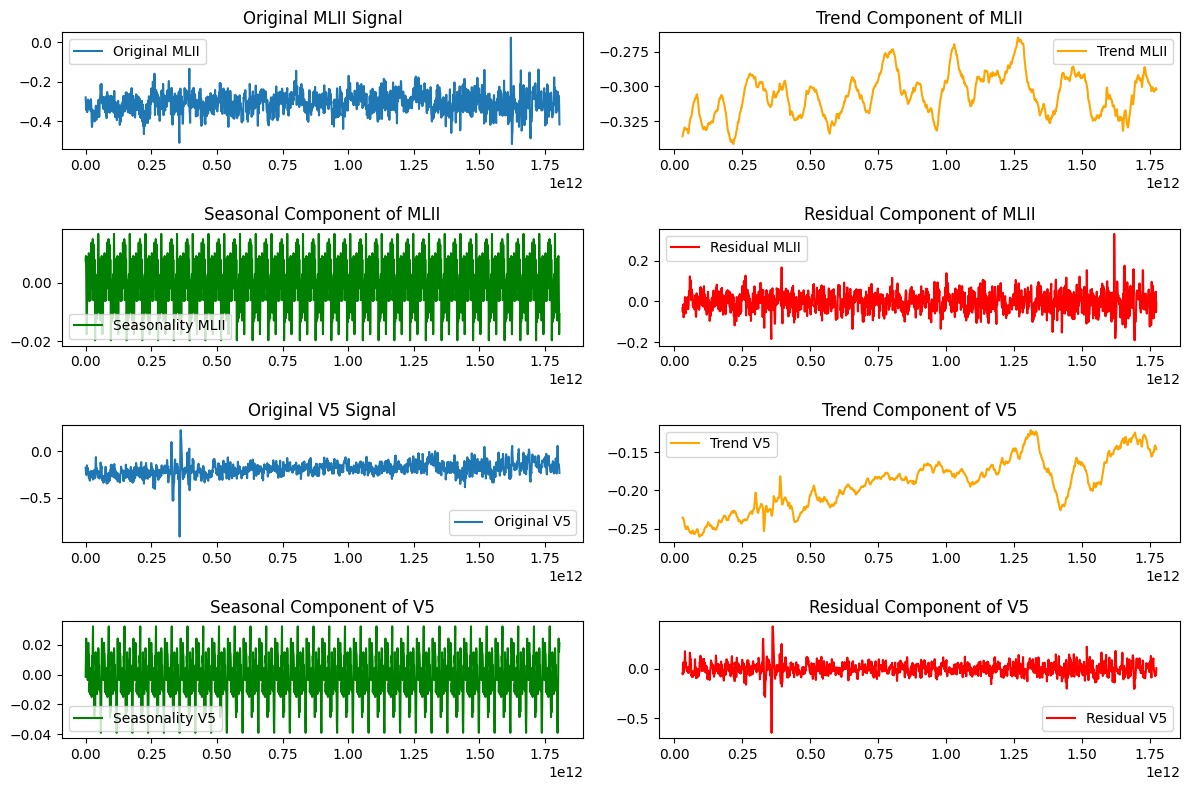

In [29]:
# For vis purposes we will use sample 100 as an example although it is already stationary

# Again we will resample the data into seconds as handling the data in ms is quite computationaly expensive

# Decompose signals using additive model (you can change to 'multiplicative' if needed)
result_V5 = seasonal_decompose(df_downsampledV5.dropna(), model='additive', period=60)  # period=60 for 1 minute seasonality
result_MLII = seasonal_decompose(df_downsampledMLII.dropna(), model='additive', period=60)  # period=60 for 1 minute seasonality

# Extract individual components
trend_V5 = result_V5.trend
seasonal_V5 = result_V5.seasonal
residual_V5 = result_V5.resid

trend_MLII = result_MLII.trend
seasonal_MLII = result_MLII.seasonal
residual_MLII = result_MLII.resid


# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
plt.plot(df_downsampledMLII, label='Original MLII')
plt.title('Original MLII Signal')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(trend_MLII, label='Trend MLII', color='orange')
plt.title('Trend Component of MLII')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(seasonal_MLII, label='Seasonality MLII', color='green')
plt.title('Seasonal Component of MLII')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(residual_MLII, label='Residual MLII', color='red')
plt.title('Residual Component of MLII')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(df_downsampledV5, label='Original V5')
plt.title('Original V5 Signal')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(trend_V5, label='Trend V5', color='orange')
plt.title('Trend Component of V5')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(seasonal_V5, label='Seasonality V5', color='green')
plt.title('Seasonal Component of V5')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(residual_V5, label='Residual V5', color='red')
plt.title('Residual Component of V5')
plt.legend()

plt.tight_layout()
plt.show()


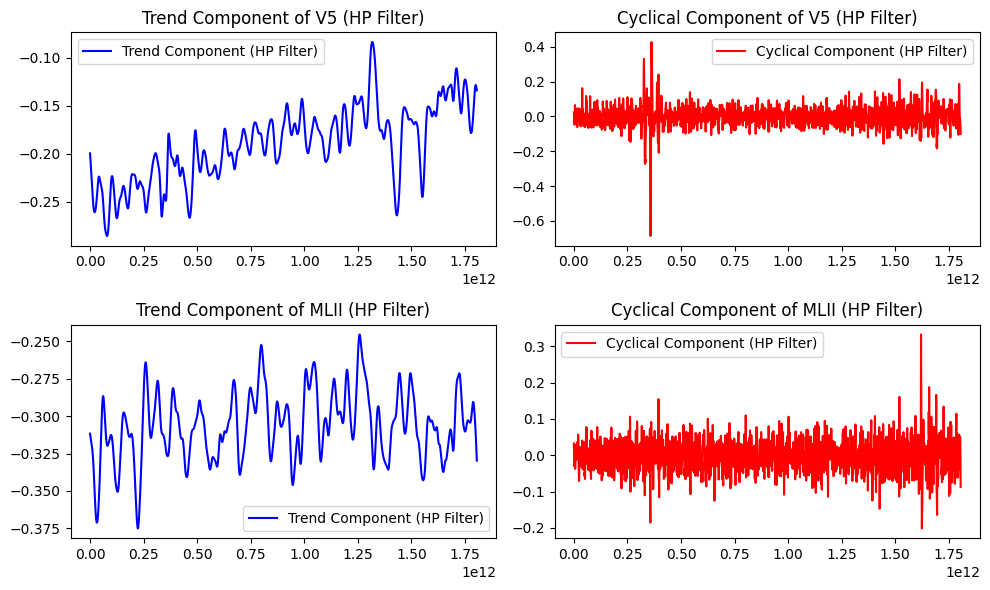

In [30]:
# For cyclical components its methods are quite different since its like a irregular seasonality
from statsmodels.tsa.filters.hp_filter import hpfilter
# To try to decompose this or detect it we could
# Apply the Hodrick-Prescott filter to V5 signal
cycle_V5, trend_V5_hp = hpfilter(df_downsampledV5.dropna(), lamb=1600)  # 'lamb' controls the smoothness (1600 for daily data)
cycle_MLII, trend_MLII_hp = hpfilter(df_downsampledMLII.dropna(), lamb=1600)

# Plot the trend and cyclical components for V5
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(trend_V5_hp, label='Trend Component (HP Filter)', color='blue')
plt.title('Trend Component of V5 (HP Filter)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(cycle_V5, label='Cyclical Component (HP Filter)', color='red')
plt.title('Cyclical Component of V5 (HP Filter)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(trend_MLII_hp, label='Trend Component (HP Filter)', color='blue')
plt.title('Trend Component of MLII (HP Filter)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(cycle_MLII, label='Cyclical Component (HP Filter)', color='red')
plt.title('Cyclical Component of MLII (HP Filter)')
plt.legend()

plt.tight_layout()
plt.show()

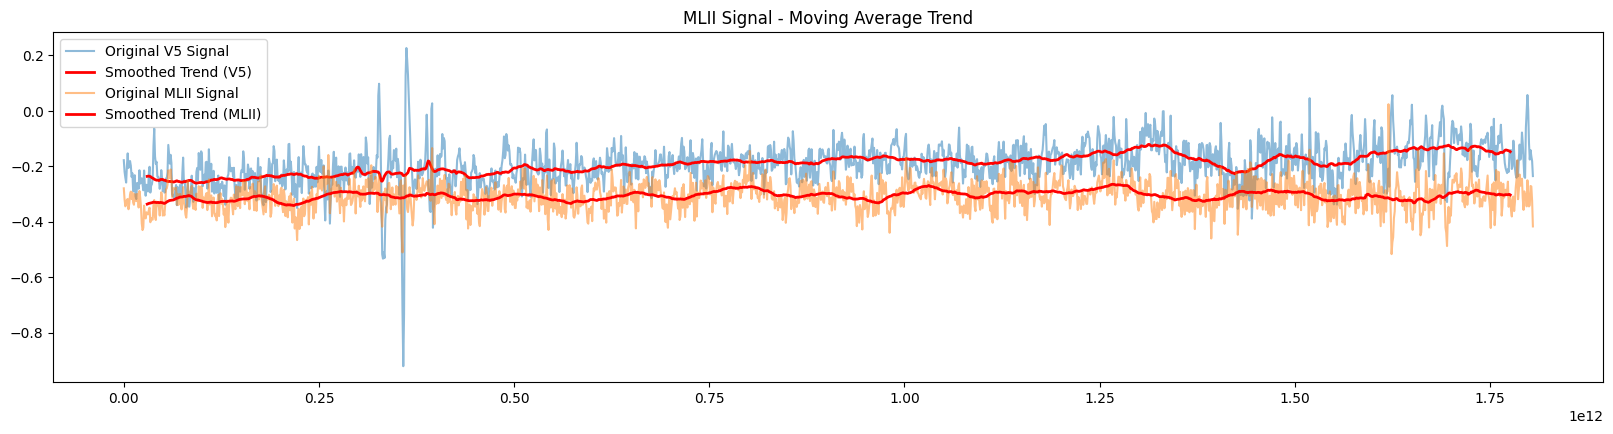

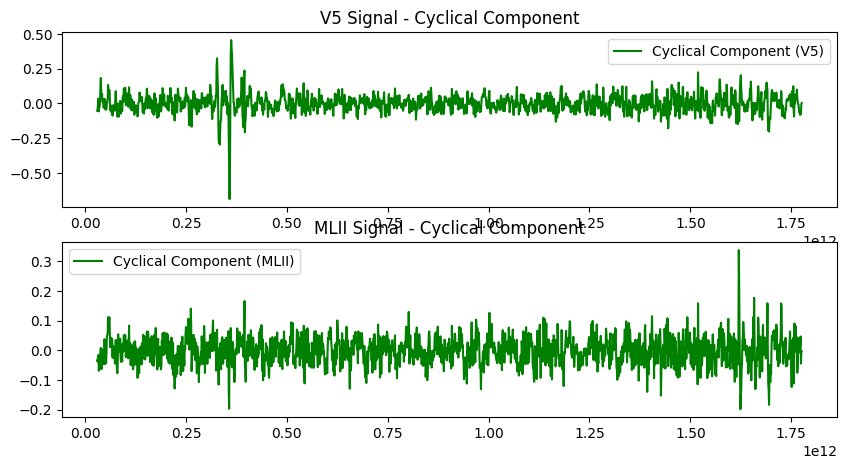

In [32]:
# Or alternatively you could apply moving average (MA) for trend extraction then extract the cylical component
window_size = 60  # 60-second window for smoothing
df_V5_trend = df_downsampledV5.rolling(window=window_size, center=True).mean()
df_MLII_trend = df_downsampledMLII.rolling(window=window_size, center=True).mean()

# Plot original data vs. smoothed trend
plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.plot(df_downsampledV5, label='Original V5 Signal', alpha=0.5)
plt.plot(df_V5_trend, label='Smoothed Trend (V5)', color='red', linewidth=2)
plt.title('V5 Signal - Moving Average Trend')
plt.legend()

plt.subplot(2,1,1)
plt.plot(df_downsampledMLII, label='Original MLII Signal', alpha=0.5)
plt.plot(df_MLII_trend, label='Smoothed Trend (MLII)', color='red', linewidth=2)
plt.title('MLII Signal - Moving Average Trend')
plt.legend()
plt.show()

# Extract the cyclical component by subtracting the trend from the original signal
df_V5_cycle = df_downsampledV5 - df_V5_trend
df_MLII_cycle = df_downsampledMLII - df_MLII_trend

# Plot the cyclical component
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(df_V5_cycle, label='Cyclical Component (V5)', color='green')
plt.title('V5 Signal - Cyclical Component')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_MLII_cycle, label='Cyclical Component (MLII)', color='green')
plt.title('MLII Signal - Cyclical Component')
plt.legend()
plt.show()

## Stats models

In [34]:
# We will be using ARIMA model

# Fit ARMA model
p = 2  # AR order
q = 1  # MA order
model_arma_v5 = ARIMA(df_downsampledV5.dropna(), order=(p, 0, q))  # 'p' is AR order, 'q' is MA order
model_arma_v5_fit = model_arma_v5.fit()
model_arma_mlii = ARIMA(df_downsampledMLII.dropna(), order=(p, 0, q))  # Choose suitable p and q based on ACF/PACF
model_arma_mlii_fit = model_arma_mlii.fit()

# Print summary of the ARMA model
print(model_arma_v5_fit.summary())
print(model_arma_mlii_fit.summary())

# Forecast future values using ARMA
forecast_arma_v5 = model_arma_v5_fit.forecast(steps=50)
print('ARMA Forecast for V5:', forecast_arma_v5)
forecast_arma_mlii = model_arma_mlii_fit.forecast(steps=50)
print('ARMA Forecast for MLII:', forecast_arma_mlii)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

                               SARIMAX Results                                
Dep. Variable:                     V5   No. Observations:                 1806
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2777.076
Date:                Tue, 08 Oct 2024   AIC                          -5544.151
Time:                        15:23:32   BIC                          -5516.657
Sample:                             0   HQIC                         -5534.003
                               - 1806                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1911      0.004    -52.175      0.000      -0.198      -0.184
ar.L1          0.1780      0.041      4.338      0.000       0.098       0.258
ar.L2          0.2343      0.033      7.126      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Autocorrelation vs Partial Autocorrelation

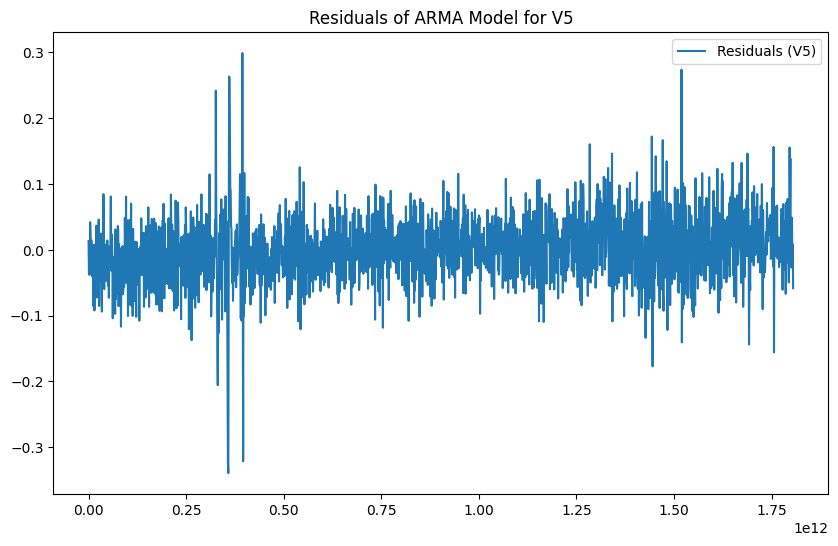

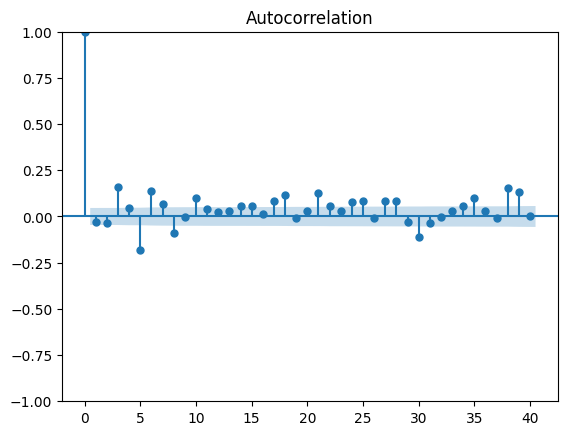

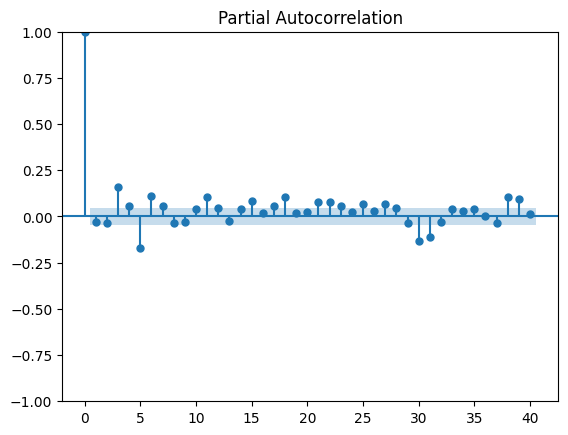

In [35]:
# Plot residuals of ARMA model (for V5 as an example)
residuals_arma_v5 = model_arma_v5_fit.resid

plt.figure(figsize=(10, 6))
plt.plot(residuals_arma_v5, label='Residuals (V5)')
plt.title('Residuals of ARMA Model for V5')
plt.legend()
plt.show()

# Check residuals of ARIMA model similarly for stationarity and normality

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF of residuals
plot_acf(residuals_arma_v5, lags=40)
plot_pacf(residuals_arma_v5, lags=40)
plt.show()

# Conclusion
In this short notebook, I've exlpored some of the topics on time series data. I acknowledge taht there are more techniques and more things to explore. But as of now, I feel the notebook have fulfilled its purpose on exploring the general time series data and its analysis.

## Topics to research next
- Play around with stock data (Known for being hard data to manage)
- Play around with MCMC and other statistical terms like Erogdicity
- Research other models like ANOVA
- Granger Casuality Test?

# References:
- https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

